In [56]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt


In [57]:
df = pd.read_csv('AAP_data.csv',index_col=['date'], parse_dates=['date'], dayfirst=True)
df

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,78.34,79.7200,78.0100,78.90,1298137,AAP
2013-02-11,78.65,78.9100,77.2300,78.39,758016,AAP
2013-02-12,78.39,78.6300,77.5132,78.60,876859,AAP
2013-02-13,78.90,79.1300,77.8500,78.97,1038574,AAP
2013-02-14,78.66,79.7200,78.5850,78.84,1005376,AAP
...,...,...,...,...,...,...
2018-02-01,116.24,118.8300,115.8300,117.29,760629,AAP
2018-02-02,115.92,117.1800,113.1250,113.93,1092333,AAP
2018-02-05,113.05,114.9700,109.8100,109.86,1281592,AAP


удаляю колонки кроме date и volume. c этим буду работать

In [58]:
dff = df.volume
dff.head()

date
2013-02-08    1298137
2013-02-11     758016
2013-02-12     876859
2013-02-13    1038574
2013-02-14    1005376
Name: volume, dtype: int64

<Axes: xlabel='date'>

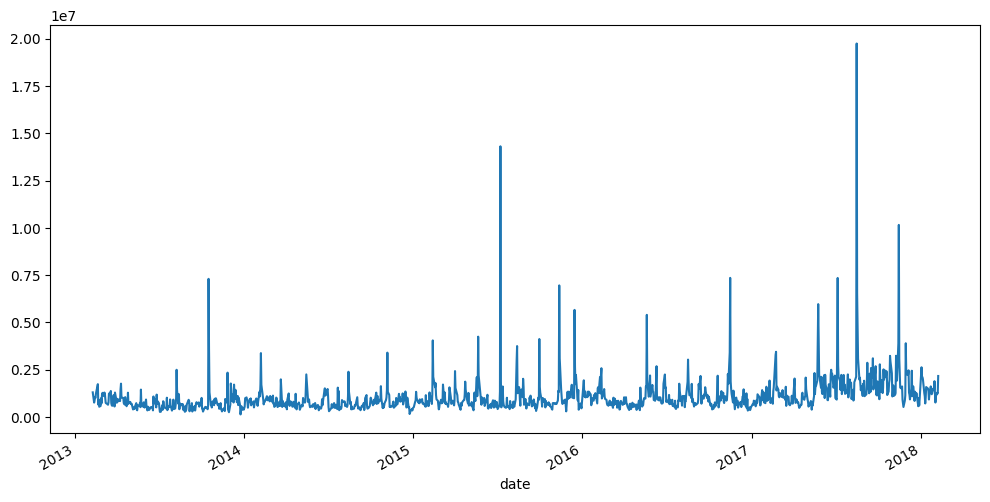

In [59]:
dff.plot(figsize=(12,6))

по графику можно понять что временной ряд стационарный, он не имеет тенденции или сезонных эффектов.

count    1.259000e+03
mean     1.078043e+06
std      1.019365e+06
min      1.307120e+05
25%      6.182010e+05
50%      8.491350e+05
75%      1.219762e+06
max      1.974952e+07
Name: volume, dtype: float64

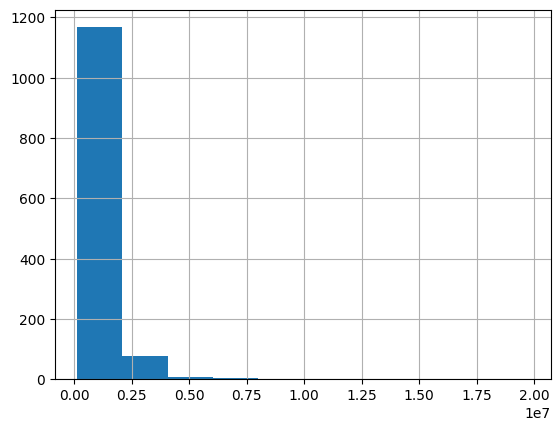

In [60]:
dff_ = dff.describe()
dff.hist()
dff_

In [61]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dff)
a = np.vstack([jb_test])
dff_ = SimpleTable(a, row)
print(dff_)

        JB        p-value        skew            kurtosis     
--------------------------------------------------------------
783887.7081473813     0.0 8.584839743122112 124.02998022768914
--------------------------------------------------------------


In [62]:
import math
import numpy as np
from scipy.stats import kstest
from scipy. stats import lognorm

kstest(dff, 'norm')


KstestResult(statistic=1.0, pvalue=0.0, statistic_location=130712, statistic_sign=-1)

In [63]:
test = sm.tsa.adfuller(dff)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -14.320405601866899
p-value:  1.1438424578271111e-26
Critical values:  {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}
единичных корней нет, ряд стационарен


вот подтверждение стационарности

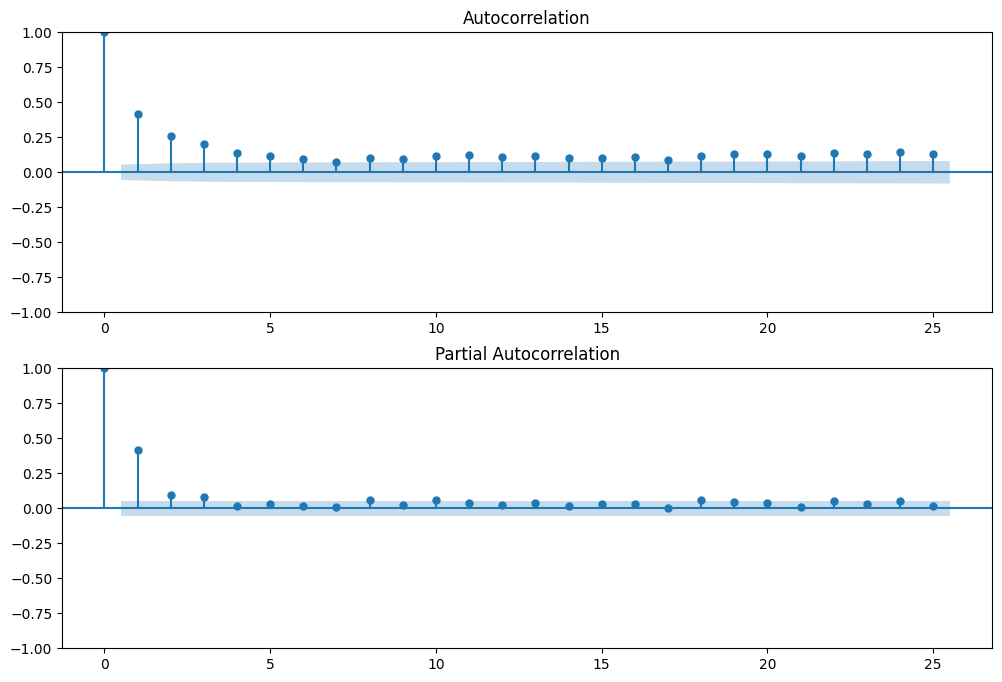

In [64]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dff, lags=25, ax=ax2)

In [93]:
mod = sm.tsa.statespace.SARIMAX(dff,
order=(1, 2, 2),
seasonal_order=(1, 2, 2, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3305      0.141      2.348      0.019       0.055       0.606
ma.L1         -1.7653      0.126    -14.043      0.000      -2.012      -1.519
ma.L2          0.8049      0.128      6.308      0.000       0.555       1.055
ar.S.L12      -0.1450      0.109     -1.336      0.182      -0.358       0.068
ma.S.L12      -1.5836      0.086    -18.391      0.000      -1.752      -1.415
ma.S.L24       0.6512      0.096      6.798      0.000       0.463       0.839
sigma2      7.791e+12   2.98e-15   2.61e+27      0.000    7.79e+12    7.79e+12


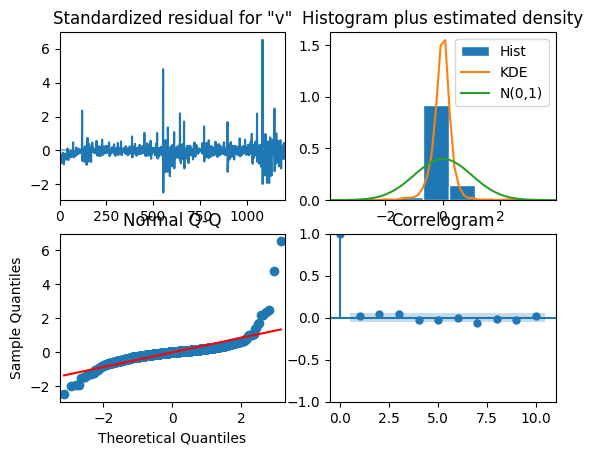

In [94]:
results.plot_diagnostics()
plt.show()

In [95]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-02-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

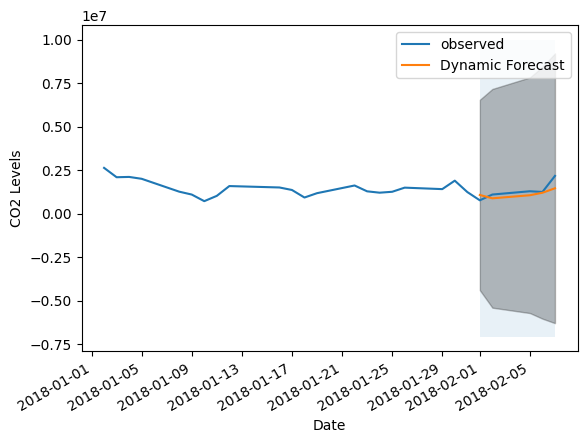

In [96]:
ax = dff['2018':].plot(label='observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-02-01'), dff.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()